In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from skimage import io, color
from tqdm import tqdm
import random
from numpy import linalg as LA
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
image_folders = glob("./shoes/*", recursive = True)

In [3]:
def only_files(dir_path):
    return [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

In [5]:
from skimage.transform import resize

scale_factor=0.2
image = imread(image_folders[0])
h, w, channels = image.shape
h = int(scale_factor*h)
w = int(scale_factor*w)

def get_image(image_path, scale_factor = 0.2):
    image = imread(image_path)
    h, w, channels = image.shape
    h = int(scale_factor*h)
    w = int(scale_factor*w)
    return resize(image, (h,w), anti_aliasing=True)



In [6]:
def extract_images(paths:list, scale_factor = 0.2):
    image = imread(paths[0])
    h, w, channels = image.shape
    h = int(scale_factor*h)
    w = int(scale_factor*w)

    A = np.zeros([len(paths), h * w * channels])
    counter = 0

    for image_path in tqdm(paths):
        im = get_image(image_path=image_path, scale_factor=scale_factor)
        if im is not None:
            A[counter, :] = im.reshape(1, -1)
            counter += 1
        else:
            continue

    return A.T

In [7]:
A = extract_images(image_folders)

100%|██████████| 337/337 [00:09<00:00, 35.98it/s]


In [8]:
labels = np.concatenate([np.ones(180),np.ones(157)*2])

In [9]:
test_size = 0.2

A_train, A_test, y_train, y_test = train_test_split(A.T, labels, test_size=test_size, random_state=47)

In [10]:
print("I will use {} images to train the model and {} images to validate it".format(
    len(A_train), len(A_test)
))

I will use 269 images to train the model and 68 images to validate it


## Bag visual words

In [12]:
from scipy.cluster.vq import kmeans,vq
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

class BagOfWords():

    def __init__(self, A_, y_train, target_w=150, channels=4, k = 1000, c_params = [1, 10, 100], gamma_params = [0.01, 0.1, 1, 10]):
        self.A_ = A_
        self.y_train = y_train
        self.target_w = target_w
        self.channels = channels
        self.n_images_paths, self.n_features = self.A_.shape
        self.k = k
        self.sift = cv2.SIFT_create()
        self.des_list, self.kp_list, self.descriptors_float = self.get_descriptors(A_=self.A_)
        print("creating centroids")
        self.voc, self.variance = kmeans(self.descriptors_float, self.k, 20)
        self.features = self.vector_quantization(self.des_list, self.n_images_paths, self.k, self.voc)
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
        self.c_params = c_params
        self.gamma_params = gamma_params
        self.model = self.train_model()


    def get_descriptors(self, A_):
        des_list = []
        kp_list = []
        images, features = A_.shape
        for i in tqdm(range(images)):
            im = A_[i,:]
            im = im.reshape([-1, self.target_w, self.channels])
            im = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            kp = self.sift.detect(im,None)
            keypoints,descriptor= self.sift.compute(im, kp)
            des_list.append(descriptor)
            kp_list.append(keypoints)

        first_ = True
        for descriptor in des_list:
            if descriptor is not None:
                if first_:
                    descriptors = descriptor
                    first_ = False
                else:
                    descriptors = np.concatenate((descriptors, descriptor))
            else:
                continue
        descriptors_float = descriptors.astype(float)
        return des_list, kp_list, descriptors_float

    def draw_keypoints(self, index=0, color=(255, 255, 255)):
        keypoints = self.kp_list[index]
        im = self.A_[index,:]
        for kp in tqdm(keypoints):
            x, y = kp.pt
            plt.imshow(cv2.circle(im, (int(x), int(y)), 2, color))

    def vector_quantization(self, des_list, n_images_paths, k, voc):
        features = np.zeros((n_images_paths, k), "float32")
        for i in tqdm(range(n_images_paths)):
            try:
                # Use the codebook to assign each observation to a cluster via vector quantization
                # labels, distance = vq(dataset, codebook)
                image_words, distance = vq(des_list[i], voc)
                for w in image_words:
                    features[i][w] += 1
            except:
                # if the image has no image_words, continue (the row will be all zeros)
                continue
        return features

    def train_model(self):

        print("sto allenando il modello")
        from sklearn.svm import SVC
        features = self.features - np.mean(self.features, axis=0)
        clf = SVC(kernel='rbf', class_weight='balanced')
        param_grid = dict(gamma=self.gamma_params, C=self.c_params)
        grid = GridSearchCV(clf, param_grid)
        grid.fit(features, self.y_train)
        return grid.best_estimator_

    def draw_keypoints(self, index = 0, color = (255, 255, 255)):
        im = self.A_[index,:].reshape([-1, self.target_w, self.channels])
        keypoints = self.kp_list[index]
        im = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        for kp in tqdm(keypoints):
            x, y = kp.pt
            plt.imshow(cv2.circle(im, (int(x), int(y)), 2, color))

    def predict(self, A_test, y_test):
        des_list, _, _ = self.get_descriptors(A_=A_test)
        n_images_path, _ = A_test.shape
        im_test_features = self.vector_quantization(des_list=des_list, n_images_paths=n_images_path, k=self.k, voc=self.voc)
        yfit = self.model.predict(im_test_features)
        print(classification_report(y_test, yfit))
        return yfit

    def transform_features(self, A_test):
        des_list, _, _ = self.get_descriptors(A_=A_test)
        n_images_path, _ = A_test.shape
        im_test_features = self.vector_quantization(des_list=des_list, n_images_paths=n_images_path, k=self.k, voc=self.voc)
        return im_test_features

In [33]:
bg_classifier = BagOfWords(A_=A_train, channels=3, k=2000, y_train=y_train, target_w=w)

100%|██████████| 269/269 [00:00<00:00, 282.04it/s]


creating centroids


100%|██████████| 269/269 [00:02<00:00, 124.32it/s]


sto allenando il modello


100%|██████████| 42/42 [00:00<00:00, 1494.18it/s]


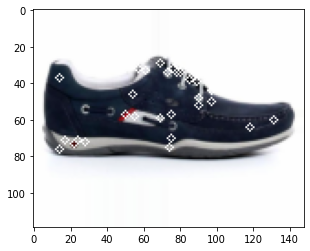

In [34]:
bg_classifier.draw_keypoints(index=10)

In [35]:
bg_classifier.predict(A_test=A_test, y_test=y_test)

100%|██████████| 68/68 [00:00<00:00, 118.19it/s]

              precision    recall  f1-score   support

         1.0       0.56      1.00      0.72        38
         2.0       0.00      0.00      0.00        30

    accuracy                           0.56        68
   macro avg       0.28      0.50      0.36        68
weighted avg       0.31      0.56      0.40        68




/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])